# Introduction
This notebook presents a practical approach to modeling Probability of Default (PD) — a core concept in credit risk assessment used by financial institutions to evaluate loan applications and manage portfolio risk.

We will use both logistic regression (as a transparent baseline) and gradient boosted trees (to capture non-linearities and interactions). The goal is to demonstrate:

- how PD models can be trained and validated,

- how different evaluation metrics behave in imbalanced classification problems,

- and how threshold selection affects business outcomes.

This project is designed to simulate a realistic decision-making scenario and highlight the trade-offs between model accuracy, recall, and profit-based strategy.

The dataset contains synthetic information on individuals who previously applied for loans. It includes demographic data, loan parameters, and whether the loan defaulted.

Selected columns:

- Age (integer): The age of the person

- Income (integer): The total yearly income

- Home ownership (category): Type of current home ownership (rent, own or mortage)

- Employment length (decimal): Number of years the person has been employed for

- Loan intent (category): Why the person has taken out the loan (e.g. debt conslidation, personal medical, ...)

- Loan grade (category): The grade of the loan (e.g. A, B, C, ...)

- Loan amount (integer): The amount that was loaned out

- Interest rate (decimal): The yearly interest that needs to be paid on the remaining principal

- Loan status (boolean): If the loan has defaulted or not (0 = non-default, 1 = default)

- Debt to income (decimal): The percentage of income used to service the outstanding debt

- Defaulted before (boolean): If the person has defaulted on a loan before

- Credit history length (integer): Years the credit history goes back for the person


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_fscore_support
from sklearn.calibration import calibration_curve
import xgboost as xgb

# Data Exploration and Cleaning

In [2]:
data = pd.read_csv('cr_loan2.csv')
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


Few missing values in ``person_emp_length`` and ``loan_int_rate`` columns.

In [5]:
rows = len(data)
missing = data[['person_emp_length', 'loan_int_rate']].isnull().sum()
pct_missing = missing / rows
print(f'Missing values in person_emp_length: {pct_missing.iloc[0]:.1%}')
print(f'Missing values in loan_int_rate: {pct_missing.iloc[1]:.1%}')

Missing values in person_emp_length: 2.7%
Missing values in loan_int_rate: 9.5%


In [6]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32416.000000,3.241600e+04,31529.00000,32416.000000,29321.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.79051,9593.845632,11.017265,0.218688,0.170250,5.811297
std,6.354100,6.201558e+04,4.14549,6322.730241,3.241680,0.413363,0.106812,4.059030
min,20.000000,4.000000e+03,0.00000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.00000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.00000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.921800e+04,7.00000,12250.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.00000,35000.000000,23.220000,1.000000,0.830000,30.000000


- Average loan amount is 10000 with a standard deviation of around 6000.
- Average default rate is 21%.
- Average interest rate is 11% with a standard deviation of around 3%.

Few quality issues:
- Max age is 144
- Max person_emp_length is 123

In [7]:
data.describe(include='O')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32416,32416,32416,32416
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16378,6411,10703,26686


In [8]:
duplicates = data[data.duplicated(keep=False)] 
counts = duplicates.value_counts().reset_index(name='Count')
counts['Count'].value_counts()

Series([], Name: count, dtype: int64)

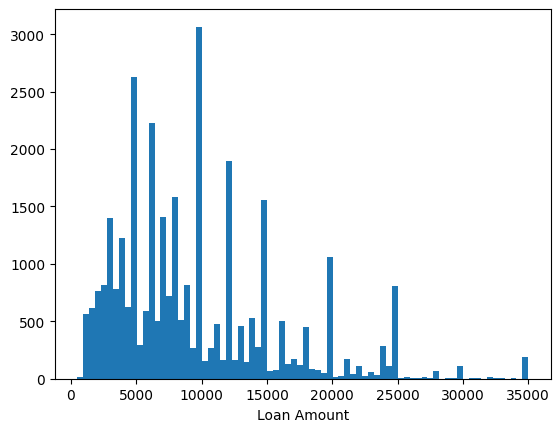

In [9]:
plt.hist(x = data['loan_amnt'], bins='auto')
plt.xlabel('Loan Amount')
plt.show()

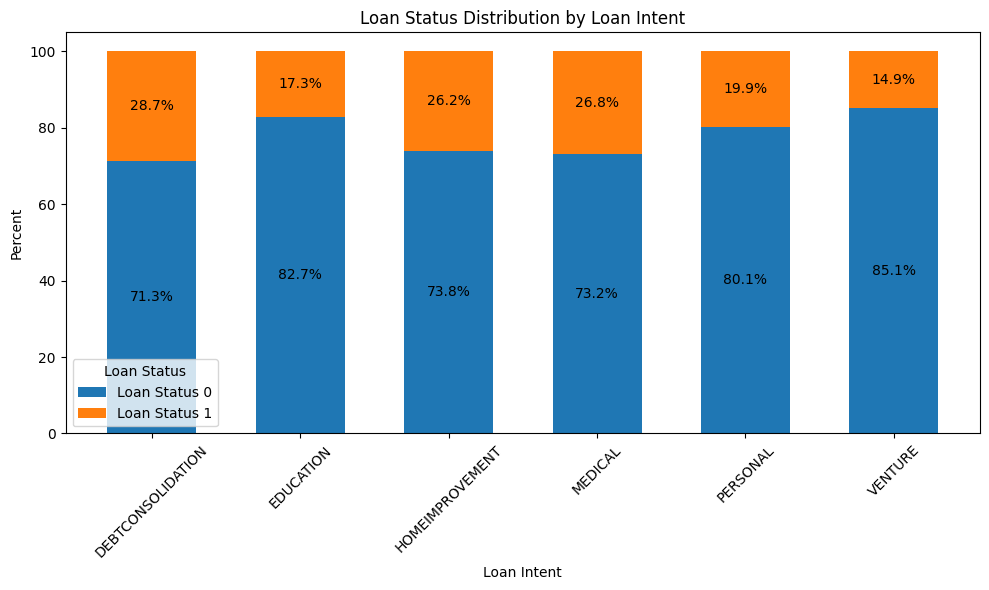

In [10]:
intents = data[['loan_status', 'loan_intent']]

counts = intents.groupby(['loan_status', 'loan_intent'], observed=True).size().reset_index(name='Count')
counts['Percent'] = counts.groupby('loan_intent')['Count'].transform(lambda x: x / x.sum() * 100)

pivot = counts.pivot(index='loan_intent', columns='loan_status', values='Percent').fillna(0)


labels = pivot.index
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))
bars0 = ax.bar(x, pivot[0], width, label='Loan Status 0')
bars1 = ax.bar(x, pivot[1], width, bottom=pivot[0], label='Loan Status 1')

for bars in [bars0, bars1]:
    ax.bar_label(bars, fmt='%.1f%%', label_type='center')

ax.set_xlabel('Loan Intent')
ax.set_ylabel('Percent')
ax.set_title('Loan Status Distribution by Loan Intent')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(title='Loan Status')

plt.tight_layout()
plt.show()


In [11]:
def remove_outliers_iqr(data, threshold=1.5):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers_removed = data[(data >= lower_bound) & (data <= upper_bound)]
    return outliers_removed

<Axes: >

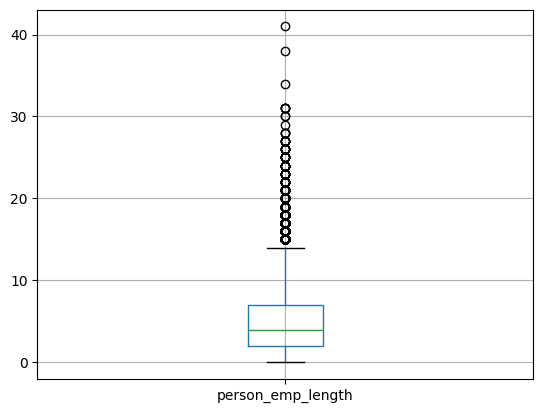

In [12]:
data_copy = data.copy()
to_remove = remove_outliers_iqr(data_copy['person_emp_length'], threshold=7.0)
#Reason for this threshold is average duration of working life.
data_copy = data_copy[data_copy['person_emp_length'].isin(to_remove)]
data_copy.boxplot(column='person_emp_length')

<Axes: >

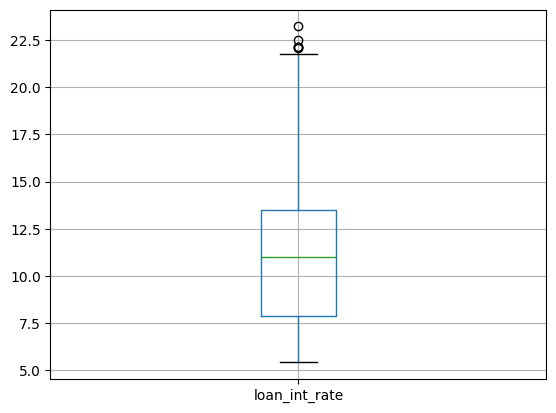

In [13]:
data_copy.boxplot(column='loan_int_rate')

In [14]:
col = data_copy['loan_int_rate']

def count_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = column[(column < lower_bound) | (column > upper_bound)]

    print(f"Liczba outlierów: {outliers.count()}")
    print(f"Procent outlierów: {100 * outliers.count() / len(column):.2f}%")

count_outliers(col)

Liczba outlierów: 6
Procent outlierów: 0.02%


<Axes: >

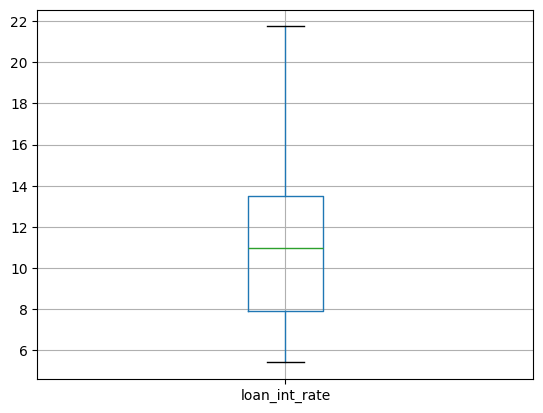

In [15]:
to_remove = remove_outliers_iqr(data_copy['loan_int_rate'])
data_copy = data_copy[data_copy['loan_int_rate'].isin(to_remove)]
data_copy.boxplot(column='loan_int_rate')

<Axes: >

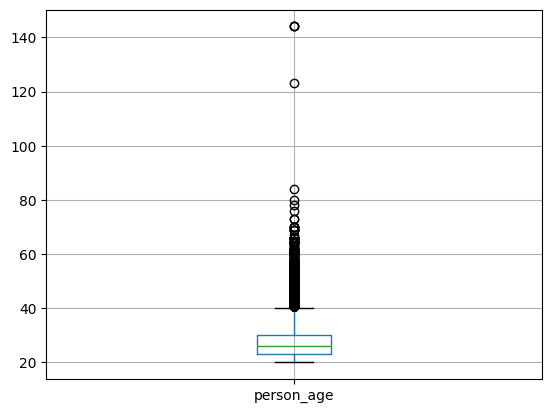

In [16]:
data_copy.boxplot(column='person_age')

In [17]:
count_outliers(data_copy['person_age'])

Liczba outlierów: 1296
Procent outlierów: 4.55%


<Axes: >

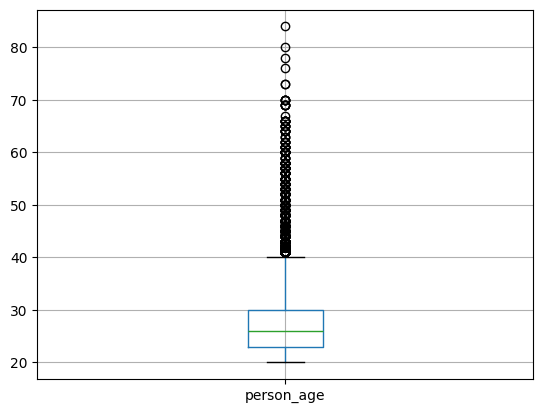

In [18]:
cleaned_col = remove_outliers_iqr(data_copy['person_age'], threshold=8.0)
data_copy = data_copy[data_copy['person_age'].isin(cleaned_col)]
data_copy.boxplot(column='person_age')

In [19]:
data_copy.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28489.000000,2.848900e+04,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000
mean,27.723262,6.642343e+04,4.781284,9656.783320,11.042839,0.216996,0.169519,5.800098
std,6.177447,5.149986e+04,4.037951,6327.433697,3.226954,0.412207,0.106382,4.040890
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,84.000000,2.039784e+06,41.000000,35000.000000,21.740000,1.000000,0.830000,30.000000


Removal of outliers seems to also handle problem of missing values.\
Data is clean and ready for modeling.

There are few categorical columns. We could use one-hot encoding for them, but we could also use label encoding.\
There is no reason to increase the dimensionality of the data with one-hot encoding, so we will use label encoding on ``cb_person_default_on_file`` and ``loan_grade`` columns.\
Reason for this is that these columns are ordinal in nature, and label encoding will preserve the order.

In [20]:
data_copy['cb_person_default_on_file'] = data_copy['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
data_copy.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,28489.000000,2.848900e+04,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000
mean,27.723262,6.642343e+04,4.781284,9656.783320,11.042839,0.216996,0.169519,0.178420,5.800098
std,6.177447,5.149986e+04,4.037951,6327.433697,3.226954,0.412207,0.106382,0.382872,4.040890
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,0.000000,8.000000
max,84.000000,2.039784e+06,41.000000,35000.000000,21.740000,1.000000,0.830000,1.000000,30.000000


In [21]:
data_copy['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [22]:
data_copy['loan_grade'] = data_copy['loan_grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})
data_copy.describe()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,28489.000000,2.848900e+04,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000
mean,27.723262,6.642343e+04,4.781284,1.229176,9656.783320,11.042839,0.216996,0.169519,0.178420,5.800098
std,6.177447,5.149986e+04,4.037951,1.169962,6327.433697,3.226954,0.412207,0.106382,0.382872,4.040890
min,20.000000,4.000000e+03,0.000000,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,0.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.600000e+04,4.000000,1.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,8.000000e+04,7.000000,2.000000,12500.000000,13.480000,0.000000,0.230000,0.000000,8.000000
max,84.000000,2.039784e+06,41.000000,6.000000,35000.000000,21.740000,1.000000,0.830000,1.000000,30.000000


That leaves two categorical columns: ``person_home_ownership`` and ``loan_intent``.\
These columns are not ordinal, so we will use one-hot encoding for them.

In [23]:
#IMPORTANT!!!
#If you are using regression drop_first=True because of multicollinearity.
data_clean_reg = pd.get_dummies(data_copy, drop_first=True, dtype=int)
data_clean_xgb = pd.get_dummies(data_copy, dtype=int)

In [24]:
data_clean_reg

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1,21,9600,5.0,1,1000,11.14,0,0.10,0,2,0,1,0,1,0,0,0,0
2,25,9600,1.0,2,5500,12.87,1,0.57,0,3,0,0,0,0,0,1,0,0
3,23,65500,4.0,2,35000,15.23,1,0.53,0,2,0,0,1,0,0,1,0,0
4,24,54400,8.0,2,35000,14.27,1,0.55,1,4,0,0,1,0,0,1,0,0
5,21,9900,2.0,0,2500,7.14,1,0.25,0,2,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,2,5800,13.16,0,0.11,0,30,0,0,0,0,0,0,1,0
32577,54,120000,4.0,0,17625,7.49,0,0.15,0,19,0,0,0,0,0,0,1,0
32578,65,76000,3.0,1,35000,10.99,1,0.46,0,28,0,0,1,0,1,0,0,0
32579,56,150000,5.0,1,15000,11.48,0,0.10,0,26,0,0,0,0,0,0,1,0


# Logistic Regression Model
I chose logistic regression as a baseline model due to its interpretability and widespread use in credit risk modeling (e.g., PD estimation). It also serves as a benchmark for evaluating more complex models.

To be thorough, we are going to check the assumptions of logistic regression before modeling.

In [25]:
#1. Binary target
data_clean_reg['loan_status'].unique()

array([0, 1])

In [26]:
#2. No strong multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data_clean_reg.drop(['loan_status', 'cb_person_cred_hist_length', 'loan_int_rate', 'loan_percent_income'], axis=1)
y = data_clean_reg['loan_status']

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

                        feature       VIF
0                    person_age  9.926873
1                 person_income  3.154514
2             person_emp_length  2.631909
3                    loan_grade  3.037941
4                     loan_amnt  3.726404
5     cb_person_default_on_file  1.709383
6   person_home_ownership_OTHER  1.008585
7     person_home_ownership_OWN  1.208555
8    person_home_ownership_RENT  2.336552
9         loan_intent_EDUCATION  1.949179
10  loan_intent_HOMEIMPROVEMENT  1.627213
11          loan_intent_MEDICAL  1.965698
12         loan_intent_PERSONAL  1.894228
13          loan_intent_VENTURE  1.909843


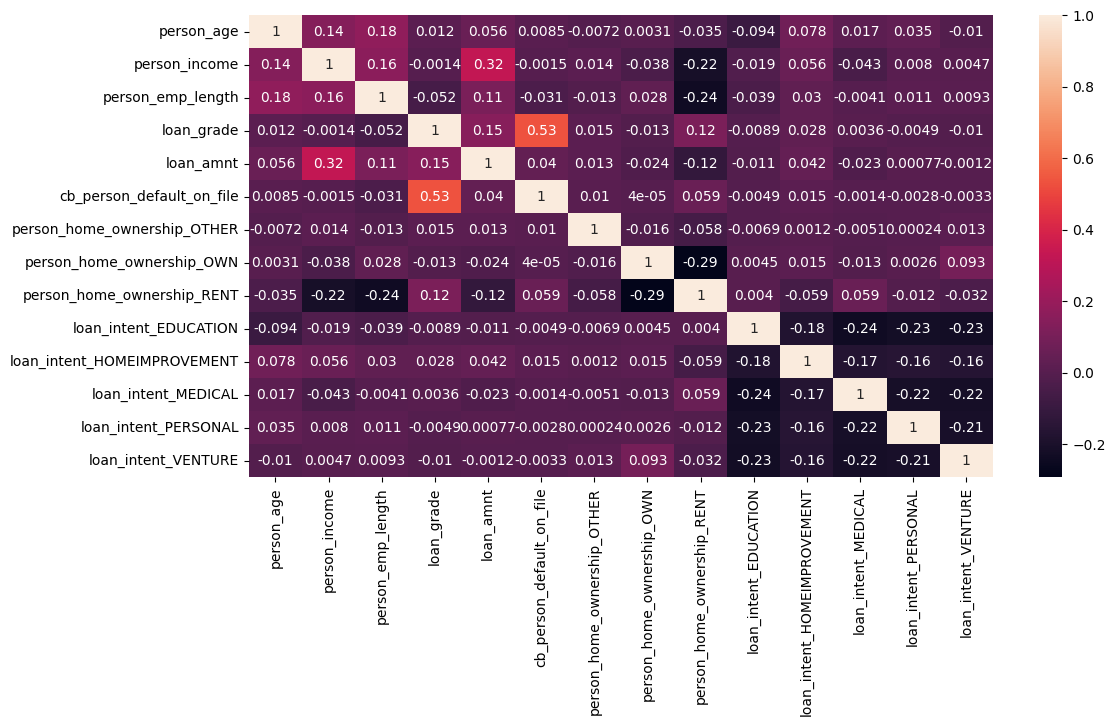

In [27]:
import seaborn as sns

plt.figure(figsize=(12,6))
ax = sns.heatmap(X.corr(), annot=True)

We are going to leave ``age`` feature as it is, regardless of VIF=9.926728.

In [28]:
#3. Observations should be independent of each other.
# We assume that they are after all data cleaning

In [29]:
X.describe()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,cb_person_default_on_file,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
count,28489.000000,2.848900e+04,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000,28489.000000
mean,27.723262,6.642343e+04,4.781284,1.229176,9656.783320,0.178420,0.003264,0.076310,0.508652,0.198954,0.111798,0.184949,0.170487,0.174243
std,6.177447,5.149986e+04,4.037951,1.169962,6327.433697,0.382872,0.057043,0.265498,0.499934,0.399220,0.315123,0.388263,0.376067,0.379325
min,20.000000,4.000000e+03,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,3.948000e+04,2.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,5.600000e+04,4.000000,1.000000,8000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30.000000,8.000000e+04,7.000000,2.000000,12500.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,2.039784e+06,41.000000,6.000000,35000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GLM
from statsmodels.genmod import families

In [31]:
#4. Linear relationship between independent variables and log odds.
bonus_var = data_clean_reg.drop(data_clean_reg[data_clean_reg.person_emp_length == 0].index)
X_lt = X.drop(X[X.person_emp_length == 0].index)
continous_var = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt']

for var in continous_var:
    X_lt[f'{var}:Log_{var}'] = X_lt[var].apply(lambda x: x * np.log(x))

columns_to_keep = continous_var + X_lt.columns.tolist()[-len(continous_var):]

X_lt = X_lt[columns_to_keep]
y_lt = bonus_var['loan_status']

X_lt = sm.add_constant(X_lt, prepend=False)

logit_res = GLM(y_lt, X_lt, family=families.Binomial()).fit()

print(logit_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            loan_status   No. Observations:                24799
Model:                            GLM   Df Residuals:                    24790
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10895.
Date:                Sun, 22 Jun 2025   Deviance:                       21790.
Time:                        19:50:04   Pearson chi2:                 3.19e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1323
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

Assumption is not satisfied for ``person_income``, ``person_emp_length``, ``loan_amnt``. I know this because of P-value < 0.05 of interaction terms.

In [32]:
#5. Large sample size
X.shape

(28489, 14)

Creating Logistic Regression model.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

logistic_model = LogisticRegression(solver='saga', max_iter=150).fit(X_train, np.ravel(y_train))

preds = logistic_model.predict_proba(X_test)

preds_of_pd = pd.DataFrame(preds[:, 1], columns=['prob_default'])

In [34]:
preds_of_pd['loan_status'] = preds_of_pd['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
preds_of_pd['loan_status'].value_counts()

loan_status
0    6774
1     349
Name: count, dtype: int64

In [35]:
print(classification_report(y_test, preds_of_pd['loan_status']))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      5561
           1       0.72      0.16      0.26      1562

    accuracy                           0.80      7123
   macro avg       0.76      0.57      0.57      7123
weighted avg       0.79      0.80      0.75      7123



The results are suboptimal. Although accuracy is high (80%), it is misleading due to the class imbalance. The model fails to capture defaults effectively, as seen by the low recall for the default class, which means that only 16% of defaults are predicted correctly.

In [36]:
preds[:, 1]

array([0.31658379, 0.03549671, 0.08006614, ..., 0.31658405, 0.17946468,
       0.31604002], shape=(7123,))

In [37]:
y_test

4268     0
28816    0
1932     0
20765    0
10586    0
        ..
16839    0
6171     0
8813     0
20868    0
4113     0
Name: loan_status, Length: 7123, dtype: int64

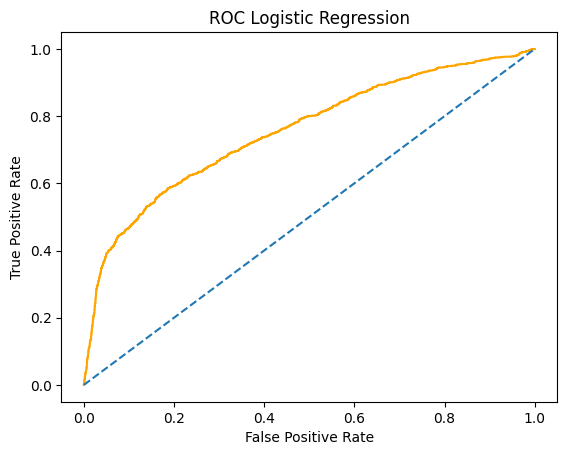

AUC:  0.7550238410403899


In [38]:
fallout, sensitivity, threshholds = roc_curve(y_test, preds[:, 1])
plt.plot(fallout, sensitivity, color='orange')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic Regression')
plt.show()

auc = roc_auc_score(y_test,preds[:, 1])
print('AUC: ', auc)

Since logistic regression outputs probabilities, Let's experiment with various decision thresholds to find the one that best balances default capture (recall) and acceptance volume. This step is crucial in real-world lending scenarios where minimizing false approvals is more important than overall accuracy.

In [39]:
preds_of_pd['loan_status'] = preds_of_pd['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

print(classification_report(y_test, preds_of_pd['loan_status']))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5561
           1       0.63      0.43      0.51      1562

    accuracy                           0.82      7123
   macro avg       0.74      0.68      0.70      7123
weighted avg       0.80      0.82      0.81      7123



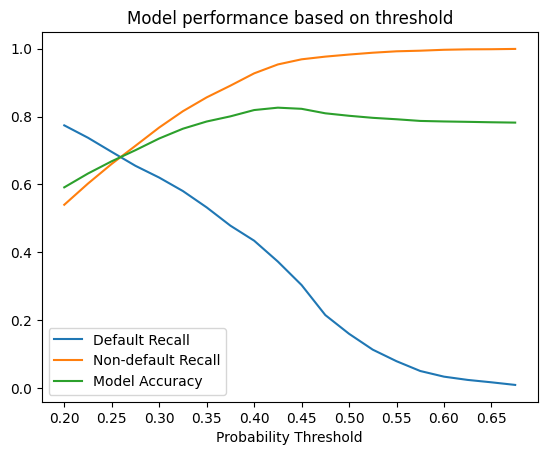

In [40]:
threshold = [0.2 + i * 0.025 for i in range(20)]
ticks = [threshold[i] for i in range(len(threshold)) if i % 2 == 0]

def_recalls = []
nondef_recalls = []
accs = []

for thresh_val in threshold:
    preds_of_pd['loan_status'] = preds_of_pd['prob_default'].apply(lambda x: 1 if x > thresh_val else 0)

    d_rec = precision_recall_fscore_support(y_test, preds_of_pd['loan_status'])[1][1]
    n_rec = precision_recall_fscore_support(y_test, preds_of_pd['loan_status'])[1][0]
    acc = accuracy_score(y_test, preds_of_pd['loan_status'])

    def_recalls.append(d_rec)
    nondef_recalls.append(n_rec)
    accs.append(acc)

plt.plot(threshold, def_recalls)
plt.plot(threshold, nondef_recalls)
plt.plot(threshold, accs)
plt.xlabel('Probability Threshold')
plt.xticks(ticks)
plt.legend(['Default Recall','Non-default Recall','Model Accuracy'])
plt.title('Model performance based on threshold')
plt.show()

From the plot below we can see that decreasing the threshold increases recall for defaulted loans, but at the cost of overall accuracy.

Also setting threshold to 0.25 isn't ideal solution for practical use as it will probably result in too many rejected loans.

Therefore, I proceed with a more flexible model — Gradient Boosted Trees — to improve default detection performance.

# Gradient Boosted Trees Model
In this section, I implement a gradient boosting classifier (XGBoost) to compare its performance against logistic regression. Tree-based models are known for capturing non-linear relationships and feature interactions, which may improve predictive power in imbalanced datasets like this one.

In [41]:
X_xgb = data_clean_xgb.drop(columns=['loan_status'], axis=1)
y_xgb = data_clean_xgb['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb, test_size=0.25, random_state=42)

In [42]:
xgb_model = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

xgb_pred = xgb_model.predict_proba(X_test)

xgb_pred_pd = pd.DataFrame(xgb_pred[:, 1], columns=['xgb_prob_default'])

In [43]:
xgb_pred_pd['loan_status'] = xgb_pred_pd['xgb_prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
print(classification_report(y_test, xgb_pred_pd['loan_status']))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5561
           1       0.95      0.72      0.82      1562

    accuracy                           0.93      7123
   macro avg       0.94      0.86      0.89      7123
weighted avg       0.93      0.93      0.93      7123



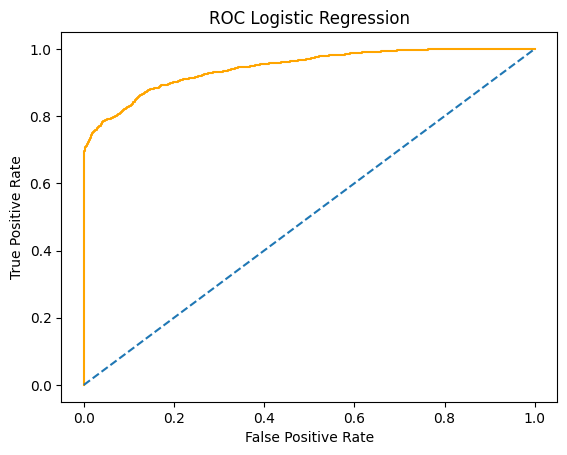

AUC:  0.9445943615461714


In [44]:
fallout, sensitivity, threshholds = roc_curve(y_test, xgb_pred[:, 1])
plt.plot(fallout, sensitivity, color='orange')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic Regression')
plt.show()

auc = roc_auc_score(y_test,xgb_pred[:, 1])
print('AUC: ', auc)

Compared to logistic regression, XGBoost achieves significantly higher recall for defaulted loans, without compromising too much on precision. This makes it more suitable for our use case, where catching potential defaults is a key priority.

Let's check Expected Loss for both models.\
I assume that LGD is 0.5.

In [45]:
X_test_amount = X_test[['loan_amnt']]

lr_pd = preds_of_pd['prob_default']
xgb_pd = xgb_pred_pd['xgb_prob_default']

portfolio = pd.concat([X_test_amount.reset_index(drop=True), lr_pd, xgb_pd], axis=1)
portfolio.head()

,loan_amnt,prob_default,xgb_prob_default
0,8000,0.316584,0.000127
1,15200,0.035497,0.059850
2,2000,0.080066,0.006128
3,5000,0.250803,0.000626
4,10000,0.413743,0.027316


In [46]:
lgd = 0.5

lr_el = portfolio['prob_default'] * lgd * portfolio['loan_amnt']
xgb_el = portfolio['xgb_prob_default'] * lgd * portfolio['loan_amnt']

print(f'Logistic Regression EL: {sum(lr_el):.2f}')
print(f'Gradient Boosted Trees EL: {sum(xgb_el):.2f}')
print(f'Saved money: {sum(lr_el) - sum(xgb_el):.2f}')

Logistic Regression EL: 8406714.59
Gradient Boosted Trees EL: 8148170.67
Saved money: 258543.91


In [47]:
n_folds = 5
early_stopping = 10
params = {'objective': 'binary:logistic', 'seed': 42, 'eval_metric': 'auc'}

data_train = xgb.DMatrix(X_train, label=y_train)

xgb.cv(params, data_train, num_boost_round=5, nfold=n_folds, early_stopping_rounds=early_stopping)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.909351,0.001134,0.903206,0.004656
1,0.917891,0.002792,0.910072,0.004332
2,0.921657,0.001586,0.914589,0.005505
3,0.925576,0.001392,0.918148,0.003910
4,0.929997,0.001470,0.922930,0.004207


In [48]:
lr_pred_pd_fin = preds_of_pd

xgb_model_fin = xgb.XGBClassifier(learning_rate=0.1, gamma=1, max_depth=8).fit(X_train, np.ravel(y_train))

xgb_pred_fin = xgb_model_fin.predict_proba(X_test)

xgb_pred_pd_fin = pd.DataFrame(xgb_pred[:, 1], columns=['xgb_prob_default'])

xgb_pred_pd_fin['loan_status'] = xgb_pred_pd_fin['xgb_prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

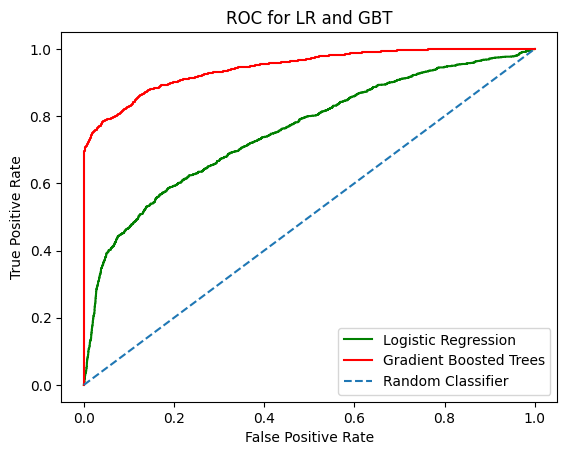

In [49]:
fallout_lr, sensitivity_lr, threshold_lr = roc_curve(y_test, lr_pred_pd_fin['prob_default'])
fallout_xgb, sensitivity_xgb, threshold_xgb = roc_curve(y_test, xgb_pred_pd_fin['xgb_prob_default'])

plt.plot(fallout_lr, sensitivity_lr, color='green', label='Logistic Regression')
plt.plot(fallout_xgb, sensitivity_xgb, color='red', label='Gradient Boosted Trees')
plt.plot([0,1], [0,1], linestyle='--', label='Random Classifier')
plt.title('ROC for LR and GBT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Choosing model in this case is straightforward.\
Gradient Boosting Trees Classifier is better than Logistic Regression.\
That leaves choosing the best threshold to maximize profit.

# Strategy
After building and evaluating both models, I now simulate a practical loan acceptance strategy based on predicted default probabilities. This allows us to estimate the potential financial impact of different thresholds.

In [50]:
y_help = pd.DataFrame(y_test)
pred_pd_fin = xgb_pred_pd_fin.drop('loan_status', axis=1)
test_pred = pd.concat([pred_pd_fin.reset_index(drop=True), y_help['loan_status'].reset_index(drop=True)], axis=1)

acceptance_rate = [round(0.05 + 0.05 * i, 2) for i in range(20)]

thresholds = []
wrong = []
num_accepted_loans = []

prob_of_def = test_pred

for rate in acceptance_rate:

    thresh = np.quantile(prob_of_def['xgb_prob_default'], rate)
    thresholds.append(thresh.round(2))

    test_pred['pred_loan_status'] = test_pred['xgb_prob_default'].apply(lambda x: 1 if x > thresh else 0)

    accepted = test_pred[test_pred['pred_loan_status'] == 0]
    num_accepted_loans.append(len(accepted))

    wrong.append(np.sum((accepted['loan_status']) / len(accepted['loan_status'])).round(2))

strategy = pd.DataFrame(zip(acceptance_rate, thresholds, wrong, num_accepted_loans), columns=['Acceptance Rate', 'Threshold', 'Wrong', 'Accepted Loans'])

strategy['Avg Loan Value'] = np.mean(X_test['loan_amnt']).round(2)
strategy['Estimated Value'] = ((strategy['Accepted Loans'] * (1 - strategy['Wrong']) * strategy['Avg Loan Value']) -
                               (strategy['Accepted Loans'] * strategy['Wrong'] * strategy['Avg Loan Value']))
    
strategy['Estimated Value'] = strategy['Estimated Value'].round(2)
strategy.sort_values(by='Estimated Value', ascending=False)

,Acceptance Rate,Threshold,Wrong,Accepted Loans,Avg Loan Value,Estimated Value
16,0.85,0.88,0.08,6054,9644.8,49047280.13
15,0.80,0.29,0.06,5698,9644.8,48361341.95
14,0.75,0.18,0.05,5342,9644.8,46370269.44
17,0.90,0.99,0.13,6410,9644.8,45749144.32
13,0.70,0.13,0.04,4986,9644.8,44241854.98
12,0.65,0.09,0.03,4630,9644.8,41976098.56
18,0.95,1.00,0.18,6766,9644.8,41764298.75
11,0.60,0.07,0.03,4274,9644.8,38748562.69
19,1.00,1.00,0.22,7123,9644.8,38471949.82
10,0.55,0.05,0.03,3918,9644.8,35521026.82


Based on the table above, we can see that the best threshold is 0.88.

# Conclusion
This notebook demonstrated the full cycle of developing a Probability of Default model — from data cleaning, through model selection and evaluation, to business-oriented threshold optimization.

Both logistic regression and gradient boosted trees were considered. While the baseline model offered interpretability, the tree-based approach significantly improved recall for defaulted loans and led to a lower expected loss. Based on this, GBT appears to be the better choice for operational deployment.